## Spatial Features Vs Urban Footprint Vs Population Size

In [1]:
import sklearn
import pandas as pd
import numpy as np
import csv
import scipy.stats as stats
from statistics import pstdev
from statistics import mean
from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.datasets import make_regression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from itertools import product
import copy


### Read the Features data

In [2]:
!ls spfeas

Sri_Lanka_spfeas.xlsx


In [3]:
spfeas = pd.read_excel('spfeas/Sri_Lanka_spfeas.xlsx', sheet_name=0)

In [4]:
spfeas['gid'] = spfeas['gid'].astype(int)
spfeas = spfeas.set_index('gid')

In [5]:
spfeas.head()

,fid,gnd_n,gnd_c,fourier_v2_sc31_mean_mean,fourier_v2_sc31_mean_std,fourier_v2_sc31_mean_sum,fourier_v2_sc31_variance_mean,fourier_v2_sc31_variance_std,fourier_v2_sc31_variance_sum,fourier_v2_sc51_mean_mean,...,sfs_sc71_min_ll_sum,sfs_sc71_roa_mean,sfs_sc71_roa_std,sfs_sc71_roa_sum,sfs_sc71_std_mean,sfs_sc71_std_std,sfs_sc71_std_sum,sfs_sc71_w_mean_mean,sfs_sc71_w_mean_std,sfs_sc71_w_mean_sum
gid,,,,,,,,,,,,,,,,,,,,,
43,0,Karagaskada South,2148065,69.388822,3.203212,2.375179e+05,18.623078,0.985125,6.374680e+04,78.463793,...,3933,136.394391,0.938602,466878,16.233955,3.648450,55568.828125,1.228705,0.707158,4205.858398
564,1,Panvila,2115070,59.471181,7.831063,1.399654e+06,17.069666,2.198242,4.017346e+05,69.620847,...,40076188,137.910516,2.093903,3245724,14.498129,5.118067,341213.468750,2.838843,3.471181,66812.164062
7917,2,Ganepalla,9227135,50.736799,5.697583,3.626159e+06,14.453749,2.114334,1.033009e+06,60.716923,...,7900571136,139.556597,2.014015,9974110,9.856942,7.202832,704475.625000,3.388618,5.864246,242184.515625
2263,3,Akkaraipattu 11,5236065,73.662439,1.809957,9.745541e+04,18.855526,1.246785,2.494586e+04,82.547466,...,1331,136.077853,0.267941,180031,10.558998,4.329045,13969.554688,0.514668,0.239074,680.906372
8,4,Delgasthenna,2109125,66.871213,2.745255,2.654118e+05,18.704186,1.010429,7.423691e+04,75.940020,...,4809,136.681028,1.377590,542487,15.218429,4.465160,60401.945312,1.180995,0.868924,4687.369141


Check data

Convert the GN_Code column to an integer index 

### Load World Pop Data

In [11]:
world_pop = pd.read_csv("world_pop/LKA_ppp_v2b_2015_UNadj.csv")

In [12]:
world_pop['gid'] = world_pop['gid'].astype(int)
world_pop = world_pop.set_index('gid')

In [13]:
world_pop.head()

,Unnamed: 0,gnd_n,gnd_c,prov_c,dis_c,dsd_c,_count,_sum,_mean,_sum_1,_mean_1,_stdev,LKA_ppp_v2b_2015_UNadj_mean,LKA_ppp_v2b_2015_UNadj_std,LKA_ppp_v2b_2015_UNadj_sum
gid,,,,,,,,,,,,,,,
43,0,Karagaskada South,2148065,2,21,2148,3424.0,2.375725e+05,69.384478,2.375725e+05,69.384478,3.204200,36.878887,10.561656,1401.397705
564,1,Panvila,2115070,2,21,2115,23528.0,1.399786e+06,59.494454,1.399786e+06,59.494454,7.828986,9.417702,6.545319,2561.614990
7917,2,Ganepalla,9227135,9,92,9227,71471.0,3.624548e+06,50.713548,3.624548e+06,50.713548,5.693804,2.561903,1.063679,2136.626953
2263,3,Akkaraipattu 11,5236065,5,52,5236,1324.0,9.756966e+04,73.693096,9.756966e+04,73.693096,1.740957,113.643473,18.693425,1363.721680
8,4,Delgasthenna,2109125,2,21,2109,3962.0,2.652974e+05,66.960471,2.652974e+05,66.960471,2.741948,42.402205,16.645848,1865.697021


In [14]:
# Total Population size

In [16]:
np.sum(world_pop['LKA_ppp_v2b_2015_UNadj_sum'])

21611273.249396127

### Load GUF

In [191]:
guf = pd.read_csv('ghs/lka_ghs.csv')

In [193]:
guf['gid'] = guf['gid'].astype(int)
guf = guf.set_index('gid')
guf.head()

,gnd_n,gnd_c,prov_c,dis_c,dsd_c,GN_Area,lka_count,lka_sum,lka_mean,ghs_count,ghs_sum,ghs_mean
gid,,,,,,,,,,,,
43,Karagaskada South,2148065,2,21,2148,337190.326,34.0,1158.294682,34.067491,235,635,2.702128
564,Panvila,2115070,2,21,2115,2316039.056,232.0,2185.832124,9.421690,1626,6326,3.890529
7917,Ganepalla,9227135,9,92,9227,7042858.261,706.0,1836.615909,2.601439,4929,6929,1.405762
2263,Akkaraipattu 11,5236065,5,52,5236,130560.240,11.0,1248.624039,113.511276,89,5889,66.168539
8,Delgasthenna,2109125,2,21,2109,390874.578,38.0,1701.824509,44.784855,274,2874,10.489051


### Merge population data with urbanfootprint and featuures

In [196]:
guf['builtup_pct'] = guf['ghs_sum']/guf['ghs_count']
guf.describe()

,gnd_c,prov_c,dis_c,dsd_c,GN_Area,lka_count,lka_sum,lka_mean,ghs_count,ghs_sum,ghs_mean,builtup_pct
count,1.402100e+04,14021.000000,14021.000000,14021.000000,1.402100e+04,14021.000000,14021.000000,14010.000000,14021.000000,14021.000000,14021.000000,14021.000000
mean,4.452103e+06,4.256116,44.265316,4451.960345,4.685756e+06,455.944998,1304.963610,13.755218,3289.723201,10023.386991,12.392446,12.392446
std,2.570367e+06,2.589969,25.680017,2570.396850,1.379027e+07,1345.392803,1121.669743,29.014800,9678.465887,17287.226087,23.920919,23.920919
min,1.103005e+06,1.000000,11.000000,1103.000000,3.765628e+04,0.000000,0.000000,0.000000,26.000000,75.000000,1.000000,1.000000
25%,2.145170e+06,2.000000,21.000000,2145.000000,9.220698e+05,90.000000,692.757784,2.361319,646.000000,2111.000000,1.035502,1.035502
50%,4.118095e+06,4.000000,41.000000,4118.000000,1.976773e+06,195.000000,1011.864489,5.027650,1386.000000,4433.000000,1.685714,1.685714
75%,6.209090e+06,6.000000,62.000000,6209.000000,4.227755e+06,413.000000,1538.584115,12.634980,2966.000000,10627.000000,7.744057,7.744057
max,9.233130e+06,9.000000,92.000000,9233.000000,5.626382e+08,54886.000000,27385.417149,683.715668,393321.000000,476350.000000,101.000000,101.000000


In [197]:
spfeas_world_pop_merged = spfeas.merge(world_pop, left_on='gid', right_on='gid', how='outer')
spfeas_guf_wp = spfeas_world_pop_merged.merge(guf, left_on='gid', right_on="gid", how='outer')

In [198]:
spfeas_guf_wp = spfeas_guf_wp.round(3)
spfeas_guf_wp.head()

,fid,gnd_n_x,gnd_c_x,fourier_v2_sc31_mean_mean,fourier_v2_sc31_mean_std,fourier_v2_sc31_mean_sum,fourier_v2_sc31_variance_mean,fourier_v2_sc31_variance_std,fourier_v2_sc31_variance_sum,fourier_v2_sc51_mean_mean,...,dis_c_y,dsd_c_y,GN_Area,lka_count,lka_sum,lka_mean,ghs_count,ghs_sum,ghs_mean,builtup_pct
gid,,,,,,,,,,,,,,,,,,,,,
43,0,Karagaskada South,2148065,69.389,3.203,237517.938,18.623,0.985,63746.797,78.464,...,21,2148,337190.326,34.0,1158.295,34.067,235,635,2.702,2.702
564,1,Panvila,2115070,59.471,7.831,1399654.250,17.070,2.198,401734.594,69.621,...,21,2115,2316039.056,232.0,2185.832,9.422,1626,6326,3.891,3.891
7917,2,Ganepalla,9227135,50.737,5.698,3626159.000,14.454,2.114,1033009.438,60.717,...,92,9227,7042858.261,706.0,1836.616,2.601,4929,6929,1.406,1.406
2263,3,Akkaraipattu 11,5236065,73.662,1.810,97455.406,18.856,1.247,24945.861,82.547,...,52,5236,130560.240,11.0,1248.624,113.511,89,5889,66.169,66.169
8,4,Delgasthenna,2109125,66.871,2.745,265411.844,18.704,1.010,74236.914,75.940,...,21,2109,390874.578,38.0,1701.825,44.785,274,2874,10.489,10.489


### Filter Dataset by Builtup Surface. 

Select Rows where  builtup is greater than or equal to 10 percent

In [199]:
filter_by_builtup = spfeas_guf_wp[spfeas_guf_wp['ghs_mean']>=10]

In [200]:
filter_by_builtup.shape

(3131, 454)

In [201]:
#np.sum(filter_by_builtup['stats_sum_y'])

In [202]:
#pop_density = filter_by_builtup['stats_sum_y']/filter_by_builtup['GN_area']

In [203]:
pop_count = filter_by_builtup['LKA_ppp_v2b_2015_UNadj_sum']
np.sum(pop_count)

7739551.6380000003

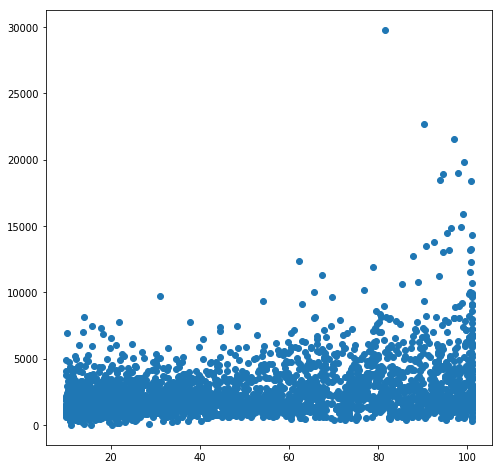

In [205]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(8,8))
y = pop_count
x = filter_by_builtup['ghs_mean']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

In [206]:
filter_by_builtup.shape

(3131, 454)

### Analysis

Get the list of dependent variables from the DataFrame to store in list y_vars

In [211]:
#y_var = list(filter_by_builtup.axes[1])[440]

y_var = list(filter_by_builtup.axes[1])[452]
y_var

'ghs_mean'

Get a list of all independent variables from the DataFrame in list all_x

In [213]:
all_x = list(filter_by_builtup.axes[1])[3:426]

#Check
all_x

['fourier_v2_sc31_mean_mean',
 'fourier_v2_sc31_mean_std',
 'fourier_v2_sc31_mean_sum',
 'fourier_v2_sc31_variance_mean',
 'fourier_v2_sc31_variance_std',
 'fourier_v2_sc31_variance_sum',
 'fourier_v2_sc51_mean_mean',
 'fourier_v2_sc51_mean_std',
 'fourier_v2_sc51_mean_sum',
 'fourier_v2_sc51_variance_mean',
 'fourier_v2_sc51_variance_std',
 'fourier_v2_sc51_variance_sum',
 'fourier_v2_sc71_mean_mean',
 'fourier_v2_sc71_mean_std',
 'fourier_v2_sc71_mean_sum',
 'fourier_v2_sc71_variance_mean',
 'fourier_v2_sc71_variance_std',
 'fourier_v2_sc71_variance_sum',
 'gabor_sc3_filter_1_mean',
 'gabor_sc3_filter_1_std',
 'gabor_sc3_filter_1_sum',
 'gabor_sc3_filter_10_mean',
 'gabor_sc3_filter_10_std',
 'gabor_sc3_filter_10_sum',
 'gabor_sc3_filter_11_mean',
 'gabor_sc3_filter_11_std',
 'gabor_sc3_filter_11_sum',
 'gabor_sc3_filter_12_mean',
 'gabor_sc3_filter_12_std',
 'gabor_sc3_filter_12_sum',
 'gabor_sc3_filter_13_mean',
 'gabor_sc3_filter_13_std',
 'gabor_sc3_filter_13_sum',
 'gabor_sc3_fi

### Compute Coorelation of features with population density

Store all features with the least correlation (stat. significance (p < 0.05)) 

The Pearson correlation coefficient **measures the linear relationship
between two datasets.** Strictly speaking, Pearson's correlation requires
that each dataset be **normally distributed, and not necessarily zero-mean.**

Like other correlation coefficients, this one varies between -1 and +1
with 0 implying no correlation. Correlations of -1 or +1 imply an exact
linear relationship. Positive correlations imply that as x increases, so
does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates **the probability of an uncorrelated system**
producing datasets that have a Pearson correlation at least as extreme
as the one computed from these datasets. 

***The p-values are not entirely
reliable but are probably reasonable for datasets larger than 500 or so.***

In [214]:
filter_by_builtup[y_var] = filter_by_builtup[y_var].fillna(0)
filter_by_builtup[y_var].isnull().values.any()

/Users/adbe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False

In [215]:
y_dict = {}
x = []

for x_var in all_x:
    
    #Calculate the Pearson statistics, 
    # returns the Pearson value and p value
    
    p = stats.skew(spfeas_world_pop_merged[x_var])
    
    #print(y_var, x_var, p)
    # print back for mike
    #print (y_var + " , " + x_var + " , " +  p)

In [216]:
y_dict = {}
x = []

for x_var in all_x:
    
    #Calculate the Pearson statistics, 
    # returns the Pearson value and p value
    
    p = stats.pearsonr(filter_by_builtup[x_var],filter_by_builtup[y_var])
    
    # print back for mike
    #print (y_var + " , " + x_var + " , " +  str(p[0]) + " , " + str(p[1]))
    
    #If p < 0.05 append to list x
    if p[1] < 0.05:
        x.append([x_var,abs(p[0])])

#List x is made into a DataFrame 
# which is sorted by the absolute values of the Pearson values
x_df = pd.DataFrame(x,columns=["x_var","abs_r2"]).sort_values("abs_r2",ascending=False)


#The dependent variable dictionary is given an entry 
# where the key is the name of the dependent variable
# and the value is a list of top 200 most significant values

y_dict[y_var] = list(x_df["x_var"][0:294])
#y_dict[y_var]
#Print out each dependent variable and 
#the number of x values that remain to check completion

In [217]:
#check 

for key in y_dict.keys():
    print(key,len(y_dict[key]))


ghs_mean 294


### Correlation Significance

For each dependent variable y in the list of all dependent values, calibrate the model.
Add new key to the output dictionary where y is the dependent variable curently being processed and the values are empty for now

In [218]:
#Initialize the output dictionary, Y_D, 
# with each key being a dependent variable and the values being the results of the analyses

Y_D = {}

Y_D[y_var]={}

#Dictionary Models is used to store each result object for later use if needed

Models ={}

#Get independent variables from the variable dictionary and store in list x_vars
x_vars = y_dict[y_var]


vars_df = pd.DataFrame()

vars_df[y_var] = filter_by_builtup[y_var]


for x in x_vars:
    vars_df[x] = filter_by_builtup[x]

In [219]:
vars_df.head()

,ghs_mean,hog_sc3_kurtosis_mean,hog_sc7_kurtosis_mean,hog_sc3_variance_std,hog_sc5_skew_mean,hog_sc5_kurtosis_mean,hog_sc7_skew_mean,hog_sc3_skew_mean,sfs_sc31_max_ll_std,fourier_v2_sc31_mean_mean,...,hog_sc5_kurtosis_sum,orb_sc51_kurtosis_std,lbpm_sc7_mean_mean,hog_sc7_kurtosis_std,orb_sc51_skew_std,orb_sc31_max_std,lbpm_sc5_max_mean,orb_sc31_variance_mean,sfs_sc51_min_ll_sum,orb_sc71_kurtosis_sum
gid,,,,,,,,,,,,,,,,,,,,,
2263,66.169,29714.148,1713686.816,0.023,3254.023,424855.492,5412.451,1124.821,7.458,73.662,...,562508672,0.000,2.372,3512679.971,0.000,0.000,14.905,0.000,1341,0.000000e+00
8,10.489,25067.152,1341415.447,0.029,2506.209,306488.279,4976.435,996.975,7.919,66.871,...,1214306560,185919.496,2.374,4347979.338,2556.833,0.016,14.436,0.000,4004,6.460194e+08
2900,25.274,25078.615,1166847.789,0.028,2673.542,302562.819,5168.198,984.272,9.660,67.161,...,5866087936,139691.803,2.374,3520753.486,1320.997,0.079,14.433,0.000,19497,2.956075e+08
631,36.635,24548.385,963190.281,0.029,2468.310,255451.642,4719.910,982.281,8.447,66.706,...,1661968384,287463.167,2.373,3059462.088,3236.007,0.000,14.614,0.000,6549,1.326253e+09
2825,90.362,32417.546,1608417.416,0.019,3372.910,414607.717,7241.316,1202.022,5.187,75.869,...,562208064,308635.189,2.371,3372091.569,2856.821,0.832,15.629,0.019,1373,1.299685e+08


### Scale/Normalize Data

In [220]:
minmax_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()

names = vars_df.columns
scaled_df = minmax_scaler.fit_transform(vars_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df.head()

,ghs_mean,hog_sc3_kurtosis_mean,hog_sc7_kurtosis_mean,hog_sc3_variance_std,hog_sc5_skew_mean,hog_sc5_kurtosis_mean,hog_sc7_skew_mean,hog_sc3_skew_mean,sfs_sc31_max_ll_std,fourier_v2_sc31_mean_mean,...,hog_sc5_kurtosis_sum,orb_sc51_kurtosis_std,lbpm_sc7_mean_mean,hog_sc7_kurtosis_std,orb_sc51_skew_std,orb_sc31_max_std,lbpm_sc5_max_mean,orb_sc31_variance_mean,sfs_sc51_min_ll_sum,orb_sc71_kurtosis_sum
0,0.617229,0.871529,0.262274,0.589744,0.732823,0.201143,0.473033,0.909440,0.632302,0.883396,...,0.016974,0.000000,0.008264,0.038028,0.000000,0.000000,0.259300,0.000000,0.000951,0.000000
1,0.005341,0.735231,0.205299,0.743590,0.564411,0.145103,0.434927,0.806074,0.671386,0.801955,...,0.036643,0.318881,0.024793,0.047071,0.411275,0.003118,0.224888,0.000000,0.003595,0.052852
2,0.167819,0.735567,0.178582,0.717949,0.602096,0.143245,0.451686,0.795803,0.818991,0.805433,...,0.177015,0.239593,0.024793,0.038116,0.212487,0.015394,0.224668,0.000000,0.018976,0.024184
3,0.292669,0.720015,0.147413,0.743590,0.555876,0.120940,0.412507,0.794194,0.716151,0.799976,...,0.050151,0.493044,0.016529,0.033122,0.520523,0.000000,0.237948,0.000000,0.006121,0.108503
4,0.883095,0.950821,0.246163,0.487179,0.759597,0.196291,0.632871,0.971859,0.439763,0.909864,...,0.016965,0.529357,0.000000,0.036506,0.459530,0.162120,0.312422,0.020256,0.000983,0.010633


In [221]:
# #Create a new dataframe for scaled and centered values
# scaled_df = pd.DataFrame()

# #Scale and center the values
# scaled_df[y_var] = scale(pop_count, with_mean=True, with_std=True)


# for x in x_vars:
#     scaled_df[x] = scale(spfeas_world_pop_merged[x], with_mean=True, with_std=True)

# scaled_df = scaled_df.round(3)

In [222]:


# Y = preprocessing.minmax_scale(vars_df[y_var])
# name='pop_sum'
# Y = pd.DataFrame(Y)
# #X = pd.DataFrame()

# X = scaler.fit_transform(vars_df[x_vars])
# X = pd.DataFrame(X, columns=x_vars)
# Y.head()

In [223]:
#X.head()

### Scale the variables

### Set Elastic net's parameters

In [224]:


enet_result = ElasticNetCV(max_iter=1e8,
                    alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1],
                    l1_ratio =[.1, .5, .7, .9, .95, .99, 1],
                    verbose= False,
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)


In [225]:
scaled_df.shape

(3131, 295)

In [226]:
# Fit the mode

In [227]:
#Fit the model with the scaled data
enet_result.fit(scaled_df[x_vars],scaled_df[y_var])
#Append the model to the Models dictionary
Models[y_var] = enet_result


In [228]:
enet_result

ElasticNetCV(alphas=[0.0005, 0.001, 0.01, 0.03, 0.05, 0.1], copy_X=True, cv=5,
       eps=0.001, fit_intercept=False,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=100000000.0,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='random',
       tol=0.0001, verbose=False)

In [229]:
opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_

#Print update to ensure that the script is progressing properly
print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[x_vars],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))

R2: 0.77 Alpha: 0.0005 l1_ratio: 0.1


Record the overall R squared score and optimal alpha 
and l1 ratio values and store them in the output dictionary


In [230]:
Y_D[y_var]['Total R2'] = enet_result.score(scaled_df[x_vars],scaled_df[y_var])
Y_D[y_var]['Alpha'] = opt_alpha
Y_D[y_var]['l1_ratio'] = opt_l1_ratio

### Ten Fold Cross validated regression

In [231]:
#Create a list R2s to store out of sample R squared values

R2s = []

#Specify the number of trials to run

trials = 10

#Run the number of trials specified in trials, 
#for each trial 66% of the observations are randomly selected to train the model
#Testing is done on the remaining 33% of observations and the R squared values are recorded

for i in range(trials):    
    X_train, X_test, y_train, y_test = train_test_split(scaled_df[x_vars],scaled_df[y_var], test_size=0.34)
    enet_regr = ElasticNetCV(max_iter=1e8,
                    alphas = [opt_alpha],
                    l1_ratio =[opt_l1_ratio],
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)
    enet_regr.fit(X_train,y_train)
    R2s.append(enet_regr.score(X_test,y_test))

#print("Mean R2: {:.2f} StDev: {:.4f}".format(mean(R2s),pstdev(R2s)))
#Record the out of sample R squared values
Y_D[y_var]['Sampling']={'trials':trials,'R2':mean(R2s),'StDev':pstdev(R2s),'R2s':R2s}
coefs = [i for i in zip(list(scaled_df[x_vars].axes[1]),enet_result.coef_)]
remaining = [i for i in coefs if abs(i[1])>0.0]
Y_D[y_var]["Coefficients"]=remaining

In [232]:
Y_D[y_var]

{'Total R2': 0.77254623065088224,
 'Alpha': 0.00050000000000000001,
 'l1_ratio': 0.10000000000000001,
 'Sampling': {'trials': 10,
  'R2': 0.76190831870601183,
  'StDev': 0.014431491482238237,
  'R2s': [0.74248577243442138,
   0.76176350186044273,
   0.78169081791427319,
   0.77109927050731397,
   0.78014969008295321,
   0.74728415144228066,
   0.74448950520710855,
   0.77914483230069143,
   0.75536450003496025,
   0.75561114527567352]},
 'Coefficients': [('hog_sc3_kurtosis_mean', 0.27804886768680859),
  ('hog_sc7_kurtosis_mean', 0.12262056284215303),
  ('hog_sc3_variance_std', -0.10716301315730246),
  ('hog_sc5_skew_mean', 0.11302017726061335),
  ('hog_sc5_kurtosis_mean', 0.066056069413879925),
  ('hog_sc7_skew_mean', 0.11774027774348329),
  ('hog_sc3_skew_mean', 0.15445687079692375),
  ('sfs_sc31_max_ll_std', -0.18159728014521456),
  ('fourier_v2_sc31_mean_mean', 0.37209420276099825),
  ('hog_sc5_variance_mean', 0.010469814172434602),
  ('hog_sc3_mean_std', -0.23786140999186739),
  ('